In [1]:
import numpy as np
import pandas as pd

from xgboost import XGBRegressor

from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score

from pandas.api.types import is_string_dtype

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import warnings
warnings.filterwarnings('ignore')

%config InlineBackend.figure_format = 'svg'

In [56]:
#Import data into a data frame'
path = 'melbourne-housing-market/'
file = 'Melbourne_housing_FULL.csv'


data = pd.read_csv(path+file) #Imports data in a data frame

#Select columns for X
cols = data.columns
cols = cols.drop('Price')

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34857 entries, 0 to 34856
Data columns (total 21 columns):
Suburb           34857 non-null object
Address          34857 non-null object
Rooms            34857 non-null int64
Type             34857 non-null object
Price            27247 non-null float64
Method           34857 non-null object
SellerG          34857 non-null object
Date             34857 non-null object
Distance         34856 non-null float64
Postcode         34856 non-null float64
Bedroom2         26640 non-null float64
Bathroom         26631 non-null float64
Car              26129 non-null float64
Landsize         23047 non-null float64
BuildingArea     13742 non-null float64
YearBuilt        15551 non-null float64
CouncilArea      34854 non-null object
Lattitude        26881 non-null float64
Longtitude       26881 non-null float64
Regionname       34854 non-null object
Propertycount    34854 non-null float64
dtypes: float64(12), int64(1), object(8)
memory usage: 5.6+ M

In [57]:
cols

Index(['Suburb', 'Address', 'Rooms', 'Type', 'Method', 'SellerG', 'Date',
       'Distance', 'Postcode', 'Bedroom2', 'Bathroom', 'Car', 'Landsize',
       'BuildingArea', 'YearBuilt', 'CouncilArea', 'Lattitude', 'Longtitude',
       'Regionname', 'Propertycount'],
      dtype='object')

In [58]:
#Drop down data instances whose Sale Price is not defined
data = data[data.Price.notnull()]

#Display 1st five instances of data
data.head()

,Suburb,Address,Rooms,Type,Price,Method,SellerG,Date,Distance,Postcode,...,Bathroom,Car,Landsize,BuildingArea,YearBuilt,CouncilArea,Lattitude,Longtitude,Regionname,Propertycount
1,Abbotsford,85 Turner St,2,h,1480000.0,S,Biggin,3/12/2016,2.5,3067.0,...,1.0,1.0,202.0,NaN,NaN,Yarra City Council,-37.7996,144.9984,Northern Metropolitan,4019.0
2,Abbotsford,25 Bloomburg St,2,h,1035000.0,S,Biggin,4/02/2016,2.5,3067.0,...,1.0,0.0,156.0,79.0,1900.0,Yarra City Council,-37.8079,144.9934,Northern Metropolitan,4019.0
4,Abbotsford,5 Charles St,3,h,1465000.0,SP,Biggin,4/03/2017,2.5,3067.0,...,2.0,0.0,134.0,150.0,1900.0,Yarra City Council,-37.8093,144.9944,Northern Metropolitan,4019.0
5,Abbotsford,40 Federation La,3,h,850000.0,PI,Biggin,4/03/2017,2.5,3067.0,...,2.0,1.0,94.0,NaN,NaN,Yarra City Council,-37.7969,144.9969,Northern Metropolitan,4019.0
6,Abbotsford,55a Park St,4,h,1600000.0,VB,Nelson,4/06/2016,2.5,3067.0,...,1.0,2.0,120.0,142.0,2014.0,Yarra City Council,-37.8072,144.9941,Northern Metropolitan,4019.0


In [37]:
#Seperate categorical from numerical data
categorical = data.select_dtypes(exclude = [np.number])
numerical = data.select_dtypes(include = [np.number])

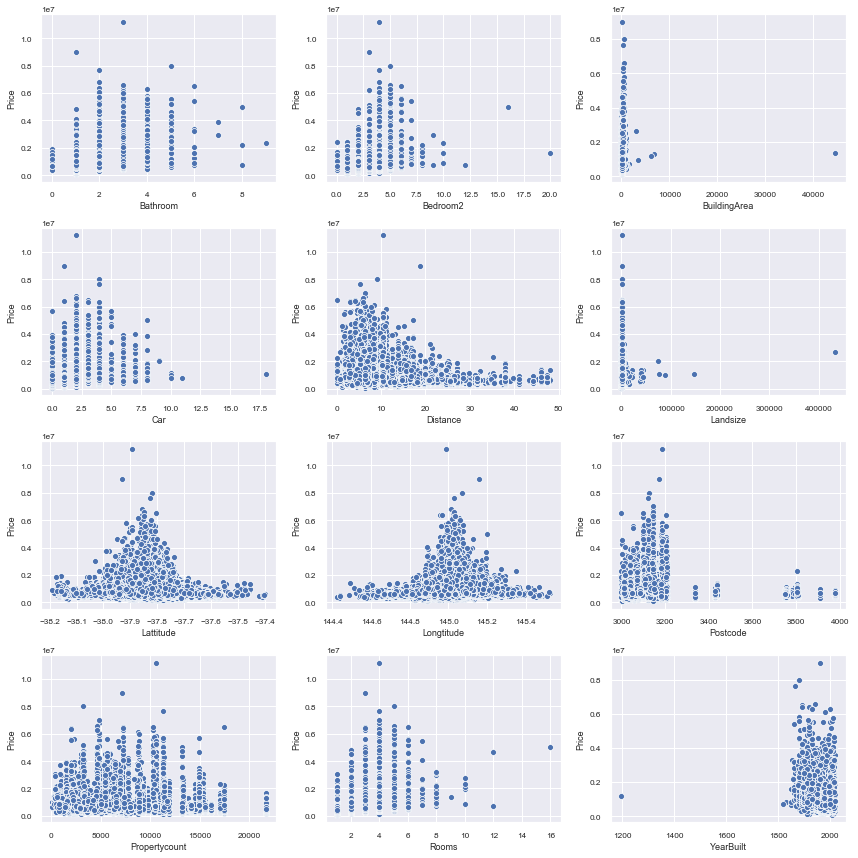

In [59]:
%config InlineBackend.figure_format = 'png'
#Plot numerical data against Sale Price
fig, axes = plt.subplots(4, 3, figsize=(12, 12))

for idx, feat in enumerate(numerical.columns.difference(['Price'])):
    ax = axes[int(idx / 3), idx%3]
    sns.scatterplot(x=feat, y='Price', data=numerical, ax=ax);
    ax.set_xlabel(feat)
    ax.set_ylabel('Price')
    
fig.tight_layout();

In [60]:
#Describe Sale Price's characteristics
data['Price'].describe()

count    2.724700e+04
mean     1.050173e+06
std      6.414671e+05
min      8.500000e+04
25%      6.350000e+05
50%      8.700000e+05
75%      1.295000e+06
max      1.120000e+07
Name: Price, dtype: float64

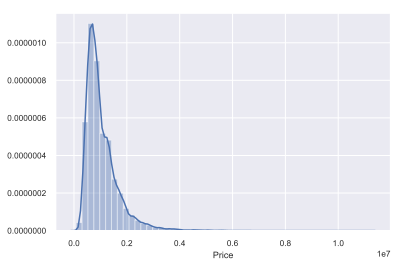

In [61]:
%config InlineBackend.figure_format = 'svg'
#Plot the SalePrice of each instance
sns.distplot(data['Price'])

In [62]:
#skewness and kurtosis
print("Skewness: %f" % data['Price'].skew())
print("Kurtosis: %f" % data['Price'].kurt())

Skewness: 2.588969
Kurtosis: 13.097201


In [63]:
#Tranform categorical data into numerical data for training purpose
for col, col_data in data.items():
    if is_string_dtype(col_data):
        data[col] = data[col].astype('category').cat.as_ordered().cat.codes

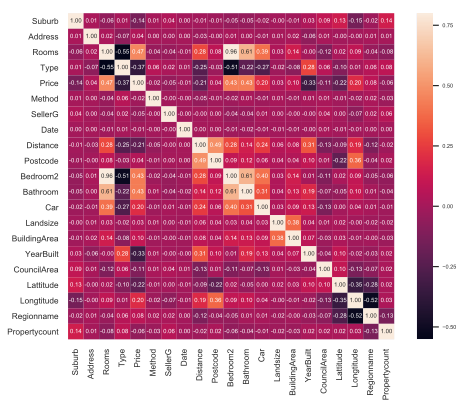

In [64]:
# SalePrice correlation matrix
corrmat = data.corr()
f, ax = plt.subplots(figsize=(8, 6))
sns.set(font_scale=0.5)
sns.heatmap(corrmat,annot=True, square=True, fmt='.2f', vmax=.8);

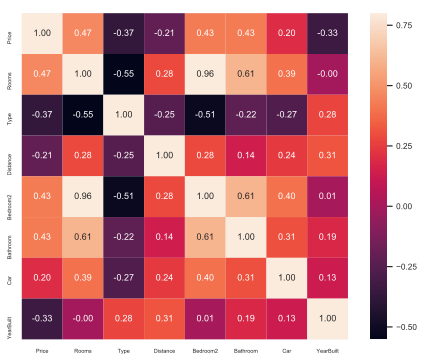

In [65]:
crcols = ['Price', 'Rooms', 'Type', 'Distance', 'Bedroom2', 'Bathroom', 'Car', 'YearBuilt']
corrmat = data[crcols].corr()
f, ax = plt.subplots(figsize=(8, 6))
sns.set(font_scale=0.75)
sns.heatmap(corrmat,annot=True, square=True, fmt='.2f', vmax=.8);

In [66]:
#Feature Selection
crcols.remove('Bedroom2')
cols = crcols
data = data[cols]
data.head()

,Price,Rooms,Type,Distance,Bathroom,Car,YearBuilt
1,1480000.0,2,0,2.5,1.0,1.0,NaN
2,1035000.0,2,0,2.5,1.0,0.0,1900.0
4,1465000.0,3,0,2.5,2.0,0.0,1900.0
5,850000.0,3,0,2.5,2.0,1.0,NaN
6,1600000.0,4,0,2.5,1.0,2.0,2014.0


In [67]:
cols

['Price', 'Rooms', 'Type', 'Distance', 'Bathroom', 'Car', 'YearBuilt']

In [68]:
#Fill in null data cells using Simple Imputer
y = data.Price
# X = SimpleImputer().fit_transform(data[cols])
X = data[['Rooms', 'Type', 'Distance', 'Bathroom', 'Car', 'YearBuilt']]

In [69]:
#Split the data into training and validation data sets
train_X, val_X, train_y, val_y = train_test_split(X, y, test_size=0.3)

imputer = SimpleImputer().fit(train_X)
train_X = imputer.transform(train_X)
val_X = imputer.transform(val_X)

#Standardize the data before feeding it to PCA algorithm
scaler = StandardScaler()
scaler.fit(train_X)

train_X = scaler.transform(train_X)
val_X = scaler.transform(val_X)

#Use PCA algorithm to reduce the number of features to speed up training 
pca = PCA(.95)
pca.fit(train_X)

train_X = pca.transform(train_X)
val_X = pca.transform(val_X)

In [70]:
#Train a model using XGBRegressor
model = XGBRegressor(n_estimators=1000, learning_rate=0.05, nthread=10)
model.fit(train_X, train_y, early_stopping_rounds=5, eval_set=[(val_X, val_y)], verbose=False)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.05, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=1000,
       n_jobs=1, nthread=10, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [55]:
model.score(val_X,val_y )

0.48726469306579279

In [34]:
#Validate the trained model using validation data-set
cvt = cross_val_score(model, train_X, train_y)

mae = cross_val_score(model, train_X, train_y, scoring = 'neg_mean_absolute_error')

print("Model Accuracy:\t",cvt.mean())
print("\nMean Absolute Error:\t",(-1 * mae.mean()))

Model Accuracy:	 0.987586205571

Mean Absolute Error:	 46065.6692129


In [32]:
#Predict Sale Price for houses in cross validation set
predict_y = model.predict(val_X)

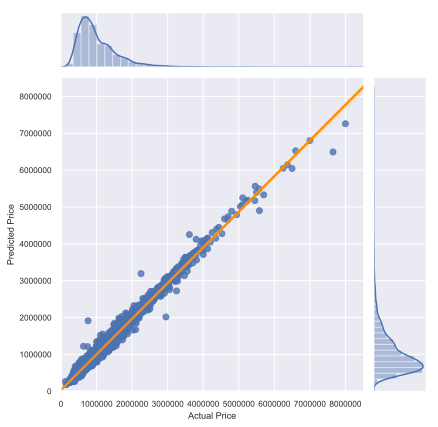

In [33]:
#Plot the actual Price value against predicted Sale Price 
g = sns.jointplot(x= val_y, y= predict_y, kind='reg', xlim=(0,8500000), ylim=(0,8500000),
                  joint_kws={'line_kws':{'color':'darkorange'}})
g.set_axis_labels(xlabel='Actual Price', ylabel='Predicted Price')